# Filters
A notebook to test filter implementation for ease of converting to `C`, `C++`, or `ino` for the Arduino.

## Initial setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Real-time peak detection (with drifting baseline)

### Create noisy signal
A quick explanation of the signal-to-noise ratio (SNR). The power for any waveform $y(t)$ over the interval $[0, T)$ is given by:

$
\quad P_y = \frac{1}{T} \int_0^T y^2(t) dt
$

The SNR is defined as the ratio of the signal ($s(t)$) power to the noise $N(t)$ power. If we assume that, over a given interval $[0, T)$:

- The signal is constant (non-random); that is, $s(t) = k \forall t \in [0, T)$.
- The noise is distributed as $\mathcal{N} (0, \sigma_N^2)$.

then the SNR becomes:

$
\begin{align}
\quad P_s 
&= \frac{1}{T} \int_0^T s^2(t) dt \\
&= \frac{1}{T} \int_0^T k^2 dt \\
&= \frac{1}{T} k^2 \int_0^T dt \\
&= \frac{1}{T} k^2 T \\
&= k^2
\end{align}
$

$
\begin{align}
\quad P_N 
&= \frac{1}{T} \int_0^T N^2(t) dt \\
&= \frac{1}{T} \int_0^T \left ( N(t) - 0 \right )^2 dt \\
&= \frac{1}{T} \int_0^T \left ( N(t) - \mathbb{E} \left [ N(t) \right ] \right )^2 dt \\
&= \sigma_N^2
\end{align}
$

$
\quad SNR = \dfrac{P_s}{P_N} = \dfrac{k^2}{\sigma_N^2}
$

or expressed in decibels:

$
\quad SNR_{dB} = 10 log_{10} \left ( \dfrac{P_s}{P_N} \right ) = 10 log_{10} \left ( \dfrac{k^2}{\sigma_N^2} \right )
$

[See here](http://www.scholarpedia.org/article/Signal-to-noise_ratio) for more details.

In [4]:
# Raw signal
T = 1000
y = np.zeros(T)

# Add noise (assume N(0, sigma_N))
sigma_N = 1.0
y += np.random.normal(loc=0.0, scale=sigma_N, size=T)

# Add peaks (assume N(SNR, 0))
SNR = 20.0 # dB
dt_signal = 5
n_signal = 10
t_signal = np.random.randint(int(0.10*T), int(min(0.9*T, T-dt_signal)), size=n_signal)
t_signal = (t_signal[:, np.newaxis] + (np.arange(dt_signal)+1)[np.newaxis, :]).flatten()
y[t_signal] += ((sigma_N**2)*(10**(SNR/10.0)))**0.5 # k = (sigma_N^2 10^(SNR_dB/10))^0.5

# Add constant drift
drift_slope = 0.01
y += np.arange(T)*drift_slope

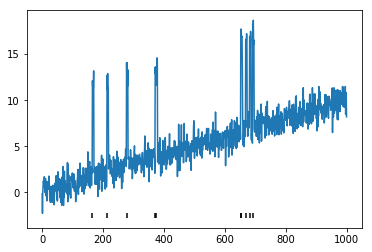

In [4]:
# Plot noisy signal
plt.plot(y)
plt.vlines(t_signal[::dt_signal], ymin=np.min(y)-0.5, ymax=np.min(y))

### Apply real-time filter
Since we are mimicking real-time, we will feed values one at a time. We will also keep in mind that we need to adapt this code to `C`, so we can't get too fancy with indexing or higher-level structures, nor do we want to store any data beyond the buffer size (in the actual implementation). 

Credit: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data

In [97]:
# Filter settings
n_filt = 50 # length of filter
thresh = 4.0 # number of stds from mean
alpha = 0.0 # influence of datapoint containing signal on buffer

# Initialize buffers
buffer = np.zeros(n_filt)
buffer[:] = y[:n_filt]
buffer_mean = np.mean(buffer)
buffer_std = np.std(buffer)
p = 0 # buffer pointer

# Placeholder (for dev purposes)
y_filt_mean = np.zeros(T) # moving average
y_filt_mean[:n_filt] = buffer_mean
y_filt_std = np.zeros(T)
y_filt_std[:n_filt] = buffer_std
x = np.zeros(T) # signal

# Feed data stream
for t in range(n_filt, T):
    # Get buffer pointer
    p = t % n_filt
    
    # Check if signal threshold passed
    if abs(y[t] - buffer_mean) > thresh*buffer_std:
        # Update signal array
        if (y[t] - buffer_mean) > 0: # positive signal
            x[t] = 1.0
        else: # negative signal
            x[t] = -1.0
            
        # Update buffer
        buffer[p] = alpha*y[t] + (1.0 - alpha)*buffer[p-1]
    else:
        # Update signal and buffer
        x[t] = 0.0
        buffer[p] = y[t]
    
    # Update buffer stats
    buffer_mean = np.mean(buffer)
    buffer_std = np.std(buffer)
    
    # Update filtered data stream (dev)
    y_filt_mean[t] = buffer_mean
    y_filt_std[t] = buffer_std

true positive rate:  0.88 (44 of 50)
false positive rate: 0.00 (0 of 950)
false negative rate: 0.00 (0 of 50)


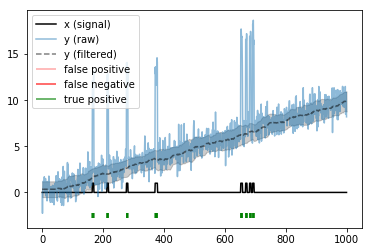

In [98]:
# Plot results
plt.plot(x, color='black', alpha=1.0, linestyle='-', label='x (signal)')
plt.plot(y, color='C0', alpha=0.5, linestyle='-', label='y (raw)')
plt.plot(y_filt_mean, color='black', alpha=0.50, linestyle='--', label='y (filtered)')
plt.fill_between(np.arange(T), y1=y_filt_mean-y_filt_std, y2=y_filt_mean+y_filt_std,
                 color='black', alpha=0.2)

# Plot ground truth
idx_gt = np.zeros(T, dtype=np.bool)
idx_gt[t_signal] = True
idx_tp = np.logical_and(x == 1.0, idx_gt)
idx_fp = np.logical_and(np.abs(x) == 1.0, ~idx_gt)
idx_fn = np.logical_and(x == 0.0, idx_gt)
plt.vlines(np.argwhere(idx_fp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.35, color='red', label='false positive')
plt.vlines(np.argwhere(idx_fn).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='red', label='false negative')
plt.vlines(np.argwhere(idx_tp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='green', label='true positive')

# Show legend
plt.legend()

# Print results
print('true positive rate:  %.2f (%d of %d)' % (np.sum(idx_tp)/(n_signal*dt_signal), np.sum(idx_tp), n_signal*dt_signal))
print('false positive rate: %.2f (%d of %d)' % (np.sum(idx_fp)/(T - n_signal*dt_signal), np.sum(idx_fp), T - n_signal*dt_signal))
print('false negative rate: %.2f (%d of %d)' % (np.sum(idx_fn)/(n_signal*dt_signal), np.sum(idx_fn), n_signal*dt_signal))

### Save filter

In [8]:
np.savetxt('testFilterData.txt', y)

### Check update functions
Rather than recalculating the new mean and standard deviation of the buffer every iteration, let's try updating the statistics based on the previous values.

In [90]:
# Filter settings
n_filt = 50 # length of filter
thresh = 3.0 # number of stds from mean
alpha = 0.0 # influence of datapoint containing signal on buffer

# Initialize buffers
buffer = np.zeros(n_filt)
buffer[:] = y[:n_filt]
buffer_mean = np.mean(buffer)
buffer_std = np.std(buffer)
p = 0 # buffer pointer

# Placeholder (for dev purposes)
y_filt_mean = np.zeros(T) # moving average
y_filt_mean[:n_filt] = buffer_mean
y_filt_std = np.zeros(T)
y_filt_std[:n_filt] = buffer_std
x = np.zeros(T) # signal

# New method placeholders
y_filt_mean_ = np.zeros(T) # moving average
y_filt_mean_[:n_filt] = buffer_mean
y_filt_std_ = np.zeros(T)
y_filt_std_[:n_filt] = buffer_std
N = n_filt

# Feed data stream
for t in range(n_filt, T):
    # Get buffer pointer
    p = t % n_filt
    
    # Cache
    buffer_old = buffer[p]
    
    # Check if signal threshold passed
    if abs(y[t] - buffer_mean) > thresh*buffer_std:
        # Update signal array
        if (y[t] - buffer_mean) > 0: # positive signal
            x[t] = 1.0
        else: # negative signal
            x[t] = -1.0
            
        # Update buffer
        buffer[p] = alpha*y[t] + (1.0 - alpha)*buffer[p-1]
    else:
        # Update signal and buffer
        x[t] = 0.0
        buffer[p] = y[t]
    
    # Update buffer stats (old method)
    buffer_mean = np.mean(buffer)
    buffer_std = np.std(buffer)
    
    # Update buffers stats (new method)
    y_filt_mean_[t] = y_filt_mean_[t-1] + (1/N)*(buffer[p] - buffer_old)
    dmean = (1/N)*(buffer[p] - buffer_old)
    y_filt_std_[t] = (y_filt_std_[t-1]**2 - (1/N)*(buffer_old - y_filt_mean_[t-1])**2 + (1/N)*(buffer[p] - y_filt_mean_[t])**2
                      + (2*dmean/N)*(buffer_old - y_filt_mean_[t-1]) + ((N-1)/N)*(dmean**2))**0.5
    
    # Update filtered data stream (dev)
    y_filt_mean[t] = buffer_mean
    y_filt_std[t] = buffer_std

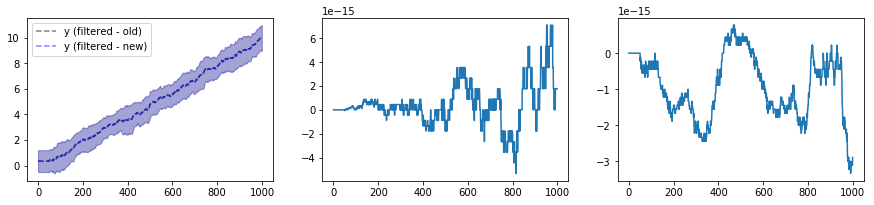

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Plot results
ax[0].plot(y_filt_mean, color='black', alpha=0.50, linestyle='--', label='y (filtered) (old)')
ax[0].fill_between(np.arange(T), y1=y_filt_mean-y_filt_std, y2=y_filt_mean+y_filt_std,
                 color='black', alpha=0.2)
ax[0].plot(y_filt_mean_, color='blue', alpha=0.50, linestyle='--', label='y (filtered) (new)')
ax[0].fill_between(np.arange(T), y1=y_filt_mean_-y_filt_std_, y2=y_filt_mean_+y_filt_std_,
                 color='blue', alpha=0.2)
ax[0].legend()

# Plot differences
ax[1].plot(y_filt_mean - y_filt_mean_)
ax[2].plot(y_filt_std - y_filt_std_)

Pretty accurate with some drifting over time. It looks like a nice compromise would be to recalculate the ground truth mean and standard deviation every so many iterations to zero out the drift occasionally.

### c++ implementation

In [2]:
y_cpp = np.loadtxt('../data/testFilterData.txt')
x_cpp = np.loadtxt('../data/signal.txt')

true positive rate:  0.00 (0 of 50)
false positive rate: 0.05 (44 of 950)
false negative rate: 0.94 (47 of 50)


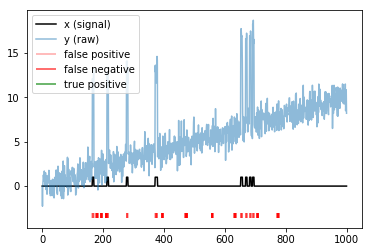

In [5]:
# Plot results
plt.plot(x_cpp, color='black', alpha=1.0, linestyle='-', label='x (signal)')
plt.plot(y_cpp, color='C0', alpha=0.5, linestyle='-', label='y (raw)')

# Plot ground truth
idx_gt = np.zeros(T, dtype=np.bool)
idx_gt[t_signal] = True
idx_tp = np.logical_and(x_cpp == 1.0, idx_gt)
idx_fp = np.logical_and(np.abs(x_cpp) == 1.0, ~idx_gt)
idx_fn = np.logical_and(x_cpp == 0.0, idx_gt)
plt.vlines(np.argwhere(idx_fp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.35, color='red', label='false positive')
plt.vlines(np.argwhere(idx_fn).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='red', label='false negative')
plt.vlines(np.argwhere(idx_tp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='green', label='true positive')

# Show legend
plt.legend()

# Print results
print('true positive rate:  %.2f (%d of %d)' % (np.sum(idx_tp)/(n_signal*dt_signal), np.sum(idx_tp), n_signal*dt_signal))
print('false positive rate: %.2f (%d of %d)' % (np.sum(idx_fp)/(T - n_signal*dt_signal), np.sum(idx_fp), T - n_signal*dt_signal))
print('false negative rate: %.2f (%d of %d)' % (np.sum(idx_fn)/(n_signal*dt_signal), np.sum(idx_fn), n_signal*dt_signal))

### Arduino implementation
The limited Arduino processor imposes a trade-off between buffer size (which increases time to update the filter) and sampling rate (which sets the minimum sampling period and thus filter update frequency). That is, the longer the buffer, the slower the sampling rate must be; otherwise, the time to update the buffer will exceed the sampling rate, leading to unintended slow buffers that lag in real-time (e.g. fill every 5 seconds instead of every second). 

EDIT: This only applies to naive buffer statistics calculations. If one-sample updates are used instead, then filter calculations take roughly constant time (see below):

| buffer size<sup>a</sup> (n) | time per iteration, one sensor (us) | time per iteration, two sensors (us) |
| --------------- | ----------------------- | ----------------------- |
| 0 (no sensor)<sup>b</sup> | 500 | 500 |
| 0 (sensor only)<sup>c</sup>  | 1500 | 3300 |
| 1-1500<sup>d</sup>  | 2000 | 4300
| 2000+<sup>e</sup> | memory overflow | memory overflow

a. The *total* number of elements across all filters (e.g. one filter with a buffer size of 1000, or two buffers with a size of 500 each)

b. only `time` and `Serial.print()` functions

c. above plus `CapacitiveSensor(30)`

d. above plus `MovingFilter` of type `long`

e. Arduino MEGA 2560

Given the above memory and time constraints, the following guidelines should be followed:

$
\quad sampleRate \leq \frac{500}{nSensors} \\
\quad tFilter \leq \frac{1500}{(nSensors)(sampleRate)}
$

## Appendix

### One-sample update

While the mean and standard deviation of the buffer can be trivially calculated from their definitions:

$
\quad \mu = \frac{1}{N} \sum_n y_n \\
\quad \sigma^2 = \frac{1}{N} \sum_n \left ( y_n - \mu \right )^2
$

this can become expensive with larger buffers (growing $\sim O(N)$). Since the time to update the buffer statistics limits the rate at which the signal can be detected, minimizing calculation time is important. This can be done by updating the current statistics based only on the new sample. Let's say the new sample $x'_j$ replaces the old sample $x_j$ at the $j^{th}$ position in the buffer. The new mean $\mu'$ becomes:

$
\quad \mu  = \frac{1}{N} \left ( \sum_{i \neq j} x_i + x_j  \right ) \\
\quad \mu' = \frac{1}{N} \left ( \sum_{i \neq j} x_i + x'_j \right ) \\
\quad \mu' - \mu = \Delta\mu = \frac{1}{N} \left ( x'_j - x_j \right ) \\
\quad \Rightarrow \mu' = \mu + \frac{1}{N} \left ( x'_j - x_j \right )
$

and the new standard deviation $\sigma'$ becomes:

$
\begin{align}
\quad \sigma^2 = \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu \right )^2 + \left ( x_j - \mu \right )^2 \right ]
\end{align}
$

$
\begin{align}
\quad \sigma'^2 
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu' \right )^2 + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - (\mu + \Delta\mu) \right )^2 + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu - \Delta\mu \right )^2 + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i^2 - 2x_i\mu + \mu^2 \right ) - \sum_{i \neq j} \left ( 2x_i\Delta\mu \right ) + \sum_{i \neq j} \left ( 2\mu\Delta\mu + \Delta\mu^2 \right ) + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu \right )^2 - 2\Delta\mu \sum_{i \neq j} x_i + \left ( N - 1 \right ) \left ( 2\mu\Delta\mu + \Delta\mu^2 \right ) + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu \right )^2 + \left (x_j - \mu \right )^2 - \left (x_j - \mu \right )^2 \right ] + \frac{1}{N} \left [ - 2\Delta\mu \left ( N\mu - x_j \right ) + \left ( N - 1 \right ) \left ( 2\mu\Delta\mu + \Delta\mu^2 \right ) + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \sigma^2 - \frac{1}{N} \left ( x_j - \mu \right )^2 + \frac{1}{N} \left ( x'_j - \mu' \right )^2 + \frac{1}{N} \left [ - 2N\mu\Delta\mu + 2\Delta\mu x_j + 2N\mu\Delta\mu + N\Delta\mu^2 - 2\mu\Delta\mu - \Delta\mu^2 \right ] \\
&= \sigma^2 - \frac{1}{N} \left ( x_j - \mu \right )^2 + \frac{1}{N} \left ( x'_j - \mu' \right )^2 + \frac{1}{N} \left [ 2\Delta\mu \left ( x_j - \mu \right ) + \left ( N - 1 \right ) \Delta\mu^2 \right ] \\
&= \sigma^2 - \frac{1}{N} \left ( x_j - \mu \right )^2 + \frac{1}{N} \left ( x'_j - \mu' \right )^2 + \frac{2\Delta\mu}{N} \left ( x_j - \mu \right ) + \frac{N - 1}{N} \Delta\mu^2
\end{align}
$

which grows with constant time. Note that some drift may occur due to rounding errors over time, which can be corrected by occassionally calculating the mean and standard deviation over the entire buffer.